In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sys
import os
import openpyxl
import re
from tqdm import tqdm


In [2]:
plt.rcParams["svg.fonttype"] = "none"

In [3]:
workbook = 'article_info.xlsx'
# workbook = openpyxl.load_workbook(workbook)
# sheet = workbook['articles_selected']

## Sorting by Effect & Data Modality

In [10]:
#cinvert the excel sheet to pandas dataframe
article_data = pd.read_excel(workbook, sheet_name='articles_clean')

In [11]:
article_data = article_data[["citation", "n_participants", "dataset", "p_factor_dims", "p_factor_analysis", "biomarker", "biomarker_type", "association"]]

In [14]:
from itertools import product

def expand_row(row, columns):
    # Split the values in each column and create a product of all combinations
    combinations = product(
        *(str(row[col]).split(', ') for col in columns)
    )
    # Create a list of dictionaries for each combination
    expanded_rows = [
        {**{col: val for col, val in zip(columns, combo)}, **row.drop(columns)}
        for combo in combinations
    ]
    return expanded_rows

# Columns to expand
columns_to_expand = ["p_factor_dims", "p_factor_analysis", "biomarker", "biomarker_type", "association"]

# Apply the expand_row function to each row
expanded_data = [expand_row(row, columns_to_expand) for index, row in article_data.iterrows()]

# Flatten the list of lists into a single list of dictionaries
flat_data = [item for sublist in expanded_data for item in sublist]

# Convert the list of dictionaries back into a DataFrame
expanded_df = pd.DataFrame(flat_data)
expanded_df = expanded_df[~((expanded_df['biomarker_type'] == 'functional') & 
                            ~(expanded_df['biomarker'].isin(['CBF', 'FC'])))]

In [16]:
def is_valid_combination(row, original_df):
    if ',' in str(row['association']):  # Check only rows with multiple values in 'association'
        # Find the original row(s) this row could have been expanded from
        original_rows = original_df[
            (original_df['citation'] == row['citation']) &
            (original_df['n_participants'] == row['n_participants']) &
            (original_df['dataset'] == row['dataset'])
        ]

        for _, original_row in original_rows.iterrows():
            # Split the original values into lists
            original_associations = str(original_row['association']).split(', ')
            original_biomarkers = str(original_row['biomarker']).split(', ')

            # Check if the current combination exists in the original row
            if len(original_associations) == len(original_biomarkers):
                try:
                    index = original_biomarkers.index(row['biomarker'])
                    if original_associations[index] == row['association']:
                        return True
                except ValueError:
                    continue
        return False
    else:
        return True

# Apply the is_valid_combination function
expanded_df = expanded_df[expanded_df.apply(is_valid_combination, axis=1, original_df=article_data)]

In [19]:
expanded_df.to_csv('expanded_articel_data.csv', index=False)


In [62]:
cols_to_expand = ["p_factor_dims", "p_factor_analysis", "biomarker", "biomarker_type", "association"]

# Function to expand a specific column and keep the original index
def expand_column(df, column):
    return df[column].str.split(', ').explode().reset_index(name=column)

# Expanding each specified column
expanded_columns = {col: expand_column(article_data, col) for col in cols_to_expand}

# Merging the expanded columns back with the original data, ensuring index alignment
sparse_df = article_data.drop(columns=cols_to_expand)
for col, df_expanded in expanded_columns.items():
    sparse_df = sparse_df.merge(df_expanded, left_index=True, right_on='index', how='left', suffixes=('', '_duplicate'))

# Dropping the additional index and duplicate columns
columns_to_remove = ['index'] + [col for col in sparse_df.columns if '_duplicate' in col]
sparse_df.drop(columns=columns_to_remove, inplace=True)

# Applying the constraints
# Constraint 1: "functional" only with "FC" or "CBF"
mask_functional = sparse_df['biomarker_type'] == 'functional'
mask_biomarker = sparse_df['biomarker'].isin(['FC', 'CBF'])
sparse_df = sparse_df[~(mask_functional & ~mask_biomarker)]

# Constraint 2: Order in "association" matches order in "biomarker"
# This constraint should already be met by the method of expansion

# Resetting the index
sparse_df.reset_index(drop=True, inplace=True)


In [64]:
sparse_df.to_csv("article_data_sparse.csv", index=False)

/var/folders/2m/72fcyjmd7vs3g18rkfwx7nw40000gn/T/ipykernel_24093/1326741071.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  article_data_1['biomarker_type_jittered'] = article_data_1['biomarker_type'].astype('category').cat.codes + 1 + np.random.uniform(-0.7, 0.1, size=len(article_data_1))
/var/folders/2m/72fcyjmd7vs3g18rkfwx7nw40000gn/T/ipykernel_24093/1326741071.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  article_data_1['association_jittered'] = article_data_1['association'].astype('category')

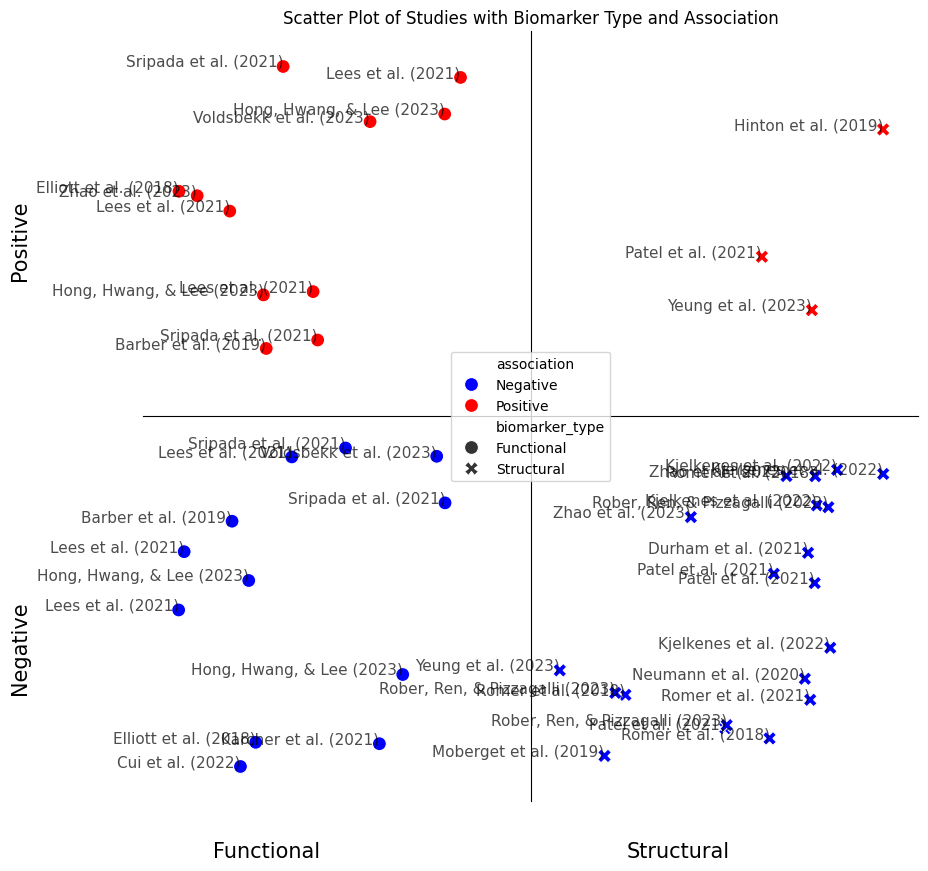

In [7]:
# Creating the scatter plot without renaming the original columns

# Adding jitter directly to the categorical columns for plotting
article_data_1['biomarker_type_jittered'] = article_data_1['biomarker_type'].astype('category').cat.codes + 1 + np.random.uniform(-0.7, 0.1, size=len(article_data_1))
article_data_1['association_jittered'] = article_data_1['association'].astype('category').cat.codes + 1 + np.random.uniform(-0.7, 0.1, size=len(article_data_1))

# Create a scatter plot
plt.figure(figsize=(10, 10))

# Plotting the scatter plot
sns.scatterplot(data=article_data_1, x='biomarker_type_jittered', y='association_jittered', hue='association', style='biomarker_type', s=100, palette=['#0000fe', '#ff0000'])


# Annotate each point with its citation
for i, row in article_data_1.iterrows():
    plt.text(row['biomarker_type_jittered'], row['association_jittered'], row['citation'], horizontalalignment='right', alpha=0.7, fontsize=11)

# Adding axis annotations for 'Negative/Positive' and 'Functional/Structural' directions
biomarker_categories = article_data_1['biomarker_type'].astype('category').cat.categories
association_categories = article_data_1['association'].astype('category').cat.categories

# Place biomarker type and association annotations
plt.text(biomarker_categories.get_loc('Functional') + 0.6, 0.1, 'Functional', ha='center', va='center', fontsize=15)
plt.text(biomarker_categories.get_loc('Structural') + 0.6, 0.1, 'Structural', ha='center', va='center', fontsize=15)
plt.text(0.000001, association_categories.get_loc('Positive') + 0.6, 'Positive', ha='center', va='center', rotation=90, fontsize=15)
plt.text(0.000001, association_categories.get_loc('Negative') + 0.6, 'Negative', ha='center', va='center', rotation=90, fontsize=15)


# Remove the default x and y ticks and labels
plt.xticks([])
plt.yticks([])
plt.xlabel('')
plt.ylabel('')

# Set the origin in the middle
plt.gca().spines['bottom'].set_position('center')
plt.gca().spines['left'].set_position('center')

# Remove top and right spines
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

plt.title('Scatter Plot of Studies with Biomarker Type and Association')
plt.savefig('scatter_plot.svg', format = 'svg', dpi=300)
plt.show()



## Dataset and Pfactor Method Frequency

In [4]:

article_data = pd.read_excel(workbook, sheet_name='dataset_pfactor_method')
dataset_data = article_data[["citation", "dataset"]].drop_duplicates(subset = ["citation"])
latent_method = article_data[["citation", "p_factor_analysis"]]

In [15]:
dataset_data

,citation,dataset
0,"Hong, Hwang, & Lee (2023)",ABCD
1,Sripada et al. (2021),ABCD
2,Romer et al. (2021),Dunedin
4,Karcher et al. (2021),ABCD
5,Elliott et al. (2018),DNC
8,Romer et al. (2018),DNC
9,Cui et al. (2022),PNC
10,Zhao et al. (2023),CBD
11,Hinton et al. (2019),TTS
12,Neumann et al. (2020),GenrR


<AxesSubplot: xlabel='dataset', ylabel='Count'>

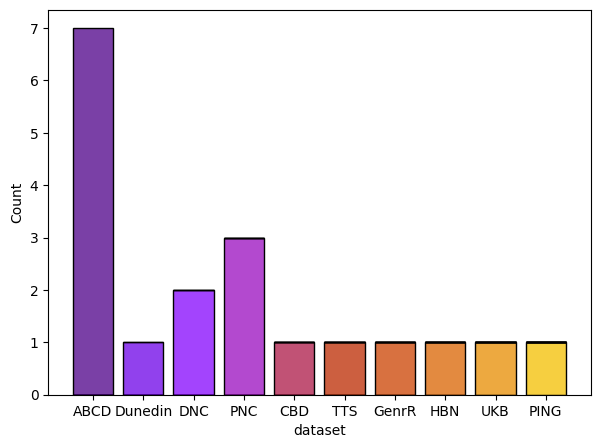

In [5]:
plt.figure(figsize=(7, 5))
sns.histplot(data=dataset_data, x='dataset', hue='dataset', multiple='stack', shrink=0.8, legend=False, palette="gnuplot")

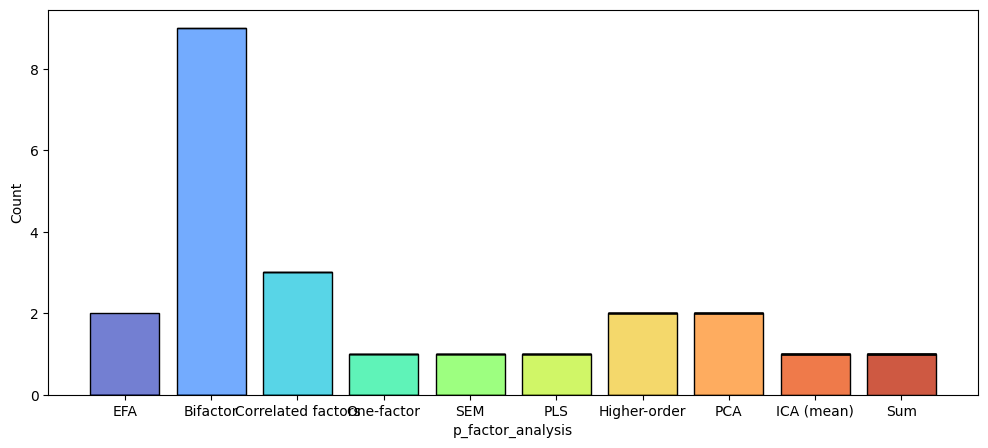

In [9]:
plt.figure(figsize=(12, 5))
sns.histplot(data=latent_method, x='p_factor_analysis', hue='p_factor_analysis', multiple='stack', shrink=0.8, legend=False, palette = "turbo")
plt.savefig('p_factor_analysis_histplot.svg', format = 'svg', dpi=300)

## Psy Dimensions

In [20]:
dim_data = pd.read_excel(workbook, sheet_name='dimensions')
dim_data = dim_data[["citation", "p_factor_dims"]]


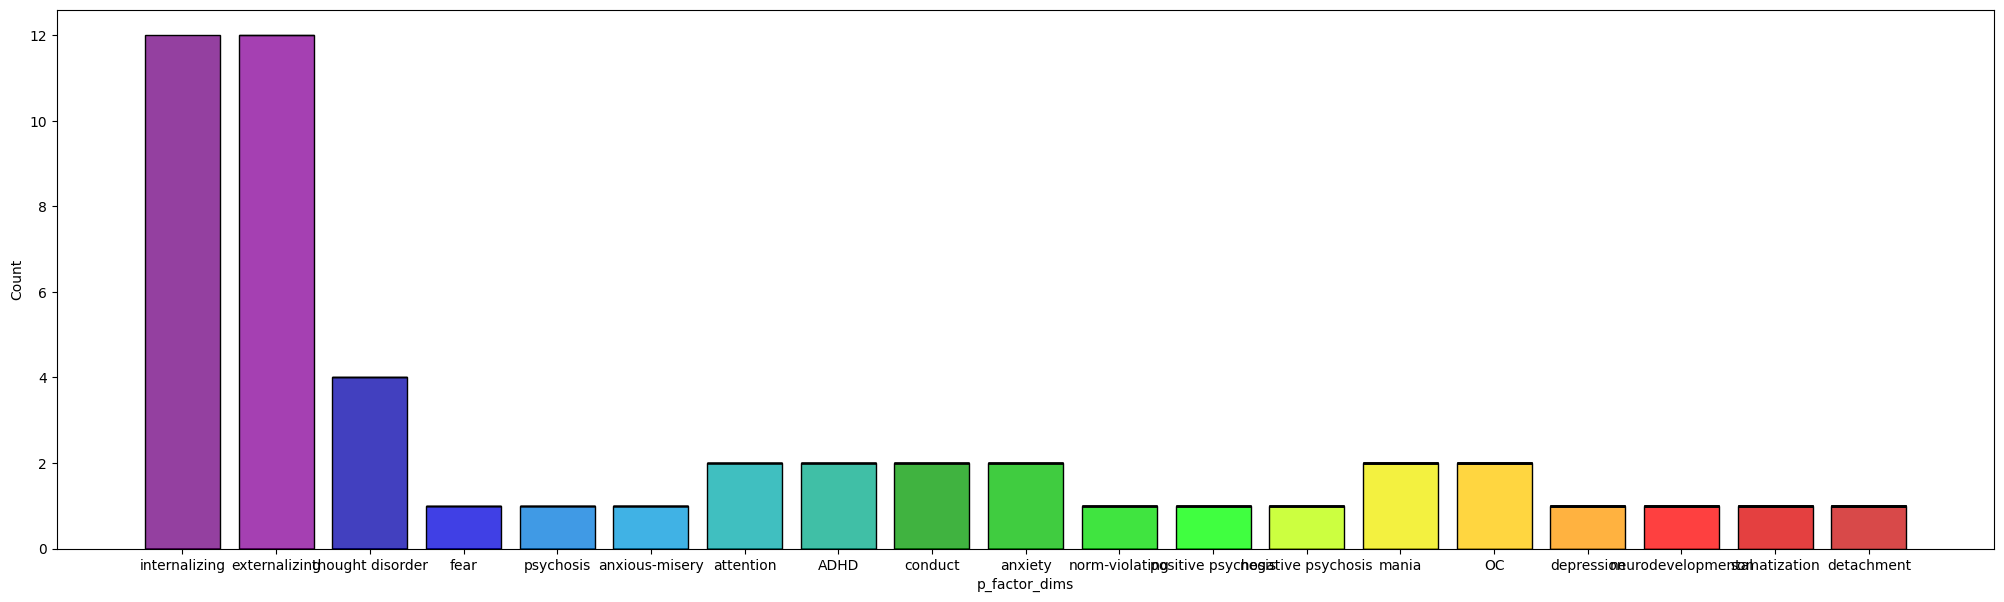

In [23]:
plt.figure(figsize=(25, 7))
sns.histplot(data=dim_data, x='p_factor_dims', hue='p_factor_dims', multiple='stack', shrink=0.8, legend=False, palette = "nipy_spectral")
plt.savefig('p_factor_dims_histplot.svg', format = 'svg', dpi=300)